In [1]:
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import Input,Dense,Conv2D,BatchNormalization,Dropout,Flatten
#Conv2DTranspose is used to go in a reverse order in neural network,reverse of feed forward
from keras.layers import Activation,Reshape,Conv2DTranspose,UpSampling2D
from keras.optimizers import RMSprop

import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
input_images = 'db/apple.npy'
data=np.load(input_images)

In [3]:
data.shape

(144722, 784)

In [4]:
data[4242]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,  36,  79,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0, 134, 238,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0, 119, 254,   4,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0, 101, 255,  21,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  82, 255,  39,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [5]:
data=data/255
data=np.reshape(data,(data.shape[0],28,28,1))
img_w,img_h=data.shape[1:3]
data.shape

(144722, 28, 28, 1)

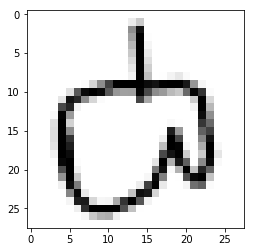

In [6]:
plt.imshow(data[4242,:,:,0],cmap='Greys')

In [7]:
# Here we a creating a convolutional network and we are increasing the depth as we go to next layer
# We are feeding the result from previous layer to new set of layers so that we can convolve on previous results.
def discriminator_builder(depth=64,p=0.4):
    inputs=Input((img_w,img_h,1))
    
    #Conv2D has 64 neurons becuase depth is defined above as 5
    #We are feeding back the first layer to same layer with a Droupout so that irrelevent pixels are droupped out.
    #Map size is 5X5 and strides the postion after which next map should be located is 2
    Conv1=Conv2D(depth*1,5,strides=2,padding='same',activation='relu')(inputs)
    Conv1=Dropout(p) (Conv1)
    
    #Here we are trying to deepen the network by increasing the neurons.
    Conv2=Conv2D(depth*2,5,strides=2,padding='same',activation='relu')(Conv1)
    Conv2=Dropout(p) (Conv2)
    
    Conv3=Conv2D(depth*4,5,strides=2,padding='same',activation='relu')(Conv2)
    Conv3=Dropout(p) (Conv3)
    
    #Here as we are increasing neurons we have reduced the position after next map should be taken
    #This helps to moniter the image more closely.
    #So after removal of waste areas from map now we can moniter the image more closely so it will focus on needed areas more effectively 
    Conv4=Conv2D(depth*8,5,strides=1,padding='same',activation='relu')(Conv3)
    Conv4=Dropout(p) (Conv4)
    
    Conv5=Conv2D(depth*16,5,strides=1,padding='same',activation='relu')(Conv4)
    Conv5=Dropout(p) (Conv5)
    
    output=Dense(1,activation='sigmoid')(Conv5)
    model=Model(inputs = inputs,outputs=output)
    model.summary()
    return model

In [8]:
discriminator=discriminator_builder()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 4, 256)         0         
__________

In [9]:
discriminator.compile(loss='binary_crossentropy',optimizer=RMSprop(lr=0.0008,decay=6e-8,clipvalue=1.0),metrics=['accuracy'])